# PhotonRate v.s. HER current

In [1]:
import epics_archiver
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

expnr = 12

timeinfo = np.load('/data_fast/hye/exp%s_goodrun_time_info.npy'%expnr, allow_pickle=True).item()

gRate = 'PXD:V:PhotonRate:RATE:cur'
her = 'SKB2:BMHDCCT:CURRENT'
pv_list = [gRate, her]
    
#### Belle2 archiver
b2_archiver = epics_archiver.epics_archiver("172.22.16.120:17668")

#### PXD archiver
pxd_archiver = epics_archiver.epics_archiver("172.22.18.80:80")

#### SVD archiver
svd_archiver = epics_archiver.epics_archiver("172.22.18.120:17668") 

data = {}
for pv in pv_list:
    data['run'] = []
    data[pv] = []
    data['time'] = []

data['%s_max'%gRate] = []

for run in sorted(timeinfo.keys()):
    try:
        start_datetime = datetime.datetime.strptime(timeinfo[run][0], "%Y-%m-%dT%H:%M:%S.%fZ")
        stop_datetime = datetime.datetime.strptime(timeinfo[run][1], "%Y-%m-%dT%H:%M:%S.%fZ")
    except Exception as e:
        try:
            start_datetime = datetime.datetime.strptime(timeinfo[run][0], "%Y-%m-%dT%H:%M:%SZ")
            stop_datetime = datetime.datetime.strptime(timeinfo[run][1], "%Y-%m-%dT%H:%M:%SZ")
        except Exception as e:
            print(run, e)
            continue
    
    if stop_datetime - start_datetime > datetime.timedelta(minutes=20):
        
        try:
            for pv in pv_list:
                if 'PXD' in pv:
                    pxd_archiver_start = pxd_archiver.date_parser(start_datetime + datetime.timedelta(minutes=5))
                    pxd_archiver_stop = pxd_archiver.date_parser(stop_datetime - datetime.timedelta(minutes=5))
                    data[pv].append(np.mean(pxd_archiver.getData(pv, pxd_archiver_start, pxd_archiver_stop)['vals']))
                    if pv == gRate:
                        data['%s_max'%pv].append(np.max(pxd_archiver.getData(pv, pxd_archiver_start, pxd_archiver_stop)['vals']))

                elif 'SKB2' in pv:
                    b2_archiver_start = b2_archiver.date_parser(start_datetime + datetime.timedelta(minutes=5))
                    b2_archiver_stop = b2_archiver.date_parser(stop_datetime - datetime.timedelta(minutes=5))
                    data[pv].append(np.mean(b2_archiver.getData(pv, b2_archiver_start, b2_archiver_stop)['vals']))
        except Exception as e:
            print(run, e)
        else:
            data['run'].append(run)
            data['time'].append(start_datetime)


# np.save('exp%s_source_cur_in_runs'%expnr,data)
print('done')

done


['PXD:V:PhotonRate:RATE:cur_max', 'SKB2:BMHDCCT:CURRENT', 'PXD:V:PhotonRate:RATE:cur', 'run', 'time']


(-196968.15540490643, 3000000.0)

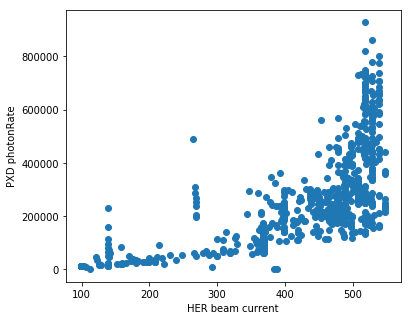

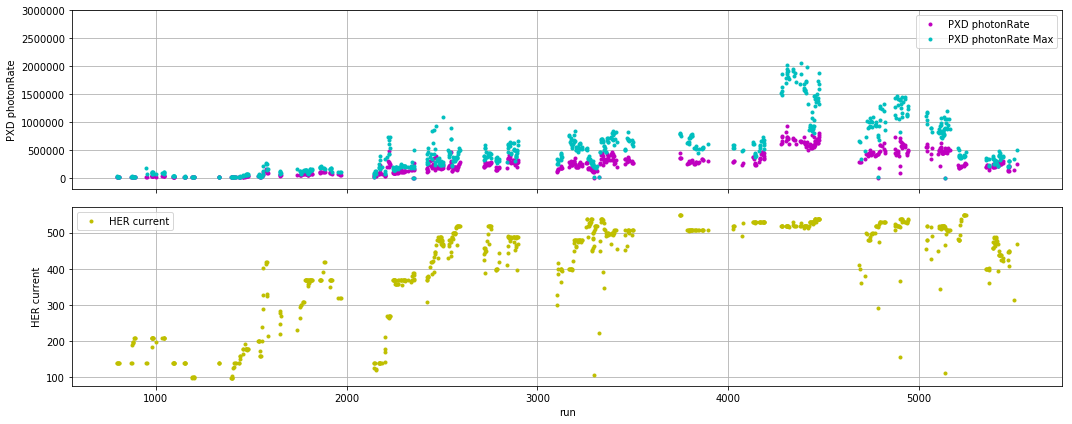

In [6]:
gRate = 'PXD:V:PhotonRate:RATE:cur'
her = 'SKB2:BMHDCCT:CURRENT'

color = ['m','y','c']

s = slice(0,-1)

print data.keys()

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(data[her][s],data[gRate][s], color='tab:blue')
ax.set_xlabel('HER beam current')
ax.set_ylabel('PXD photonRate')

labels=['PXD photonRate','HER current']
figs, axes = plt.subplots(2,1,figsize=(15,6), sharex=True, tight_layout=True)
for i,pv in enumerate([gRate,her]):
    axes[i].plot(data['run'][s], data[pv][s],c=color[i],ls='',marker='.', label=labels[i])
    axes[1].set_xlabel('run')
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid()

    
pv ='%s_max'%gRate
axes[0].plot(data['run'][s], data[pv][s],c=color[2],ls='',marker='.', label='PXD photonRate Max')
axes[0].legend()
#axes[0].grid()
axes[0].set_ylim(top=3e6)
# axes[0].set_xlim(2500,4200)


(-188192.13636689348, 3000000.0)

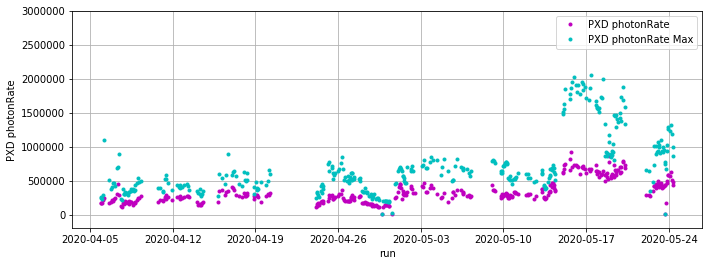

In [185]:
import datetime
import matplotlib.dates as mdate

subruns = [x for x in data['run'] if x > 2500 and x <4850]
s=slice(data['run'].index(subruns[0]),data['run'].index(subruns[-1])+1)

fig, ax = plt.subplots(figsize=(10,3.8), tight_layout=True)

pv = gRate
ax.plot_date([mdate.date2num(t) for t in data['time'][s]], data[pv][s],c=color[0],ls='',marker='.', label=labels[0])
ax.set_xlabel('run')
ax.set_ylabel(labels[0])    
pv ='%s_max'%gRate
ax.plot_date([mdate.date2num(t) for t in data['time'][s]], data[pv][s],c=color[2],ls='',marker='.', label='PXD photonRate Max')
ax.legend()
ax.grid()
ax.set_ylim(top=3e6)


4168

****************************************
Minimizer is Linear
Chi2                      =  2.36903e+12
NDf                       =          489
p0                        =        21874   +/-   21368.8     
p1                        =      -101.92   +/-   144.937     
p2                        =      1.17731   +/-   0.216201    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


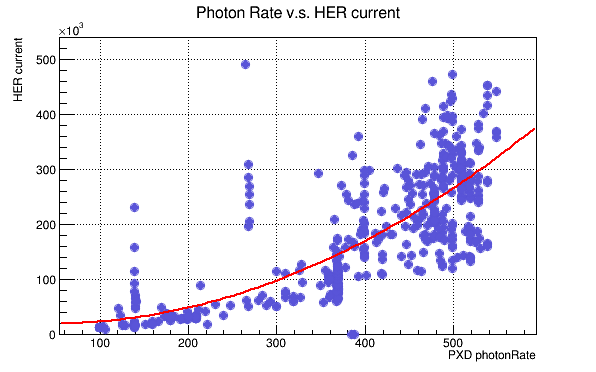

In [153]:
import ROOT
ROOT.gStyle.SetOptStat(0)
from array import array

c1 = ROOT.TCanvas('c1','c1',600,400)
# c1.SetFillColor( 42 )
c1.SetGrid()

x, y = array( 'd' ), array( 'd' )

s = slice(0,-50)
print data['run'][-50]

for i in range(len(data[gRate][s])):
    x.append(data[her][i])
    y.append(data[gRate][i])
    
gr = ROOT.TGraph(len(x),x,y)
gr.SetLineColor( 2 )
gr.SetLineWidth( 4 )
gr.SetMarkerColor( 9 )
gr.SetMarkerStyle( 20 )
gr.SetTitle( 'Photon Rate v.s. HER current' )
gr.GetXaxis().SetTitle( 'PXD photonRate' )
gr.GetYaxis().SetTitle( 'HER current' )
gr.Draw( 'AP' )

gr.Fit('pol2')

c1.Draw()
# c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderSize( 12 )
c1.Modified()
c1.Update()


In [139]:
pol2 = 2.36903e+12/489
pol1 = 2.51269e+12/490

print pol1, pol2, pol1>pol2

5127938775.51 4844642126.79 True



****************************************
Minimizer is Linear
Chi2                      =  5.40225e+10
NDf                       =           22
p0                        =      2562.94   +/-   82407.4     
p1                        =      3.03194   +/-   543.938     
p2                        =       1.0627   +/-   0.799233    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


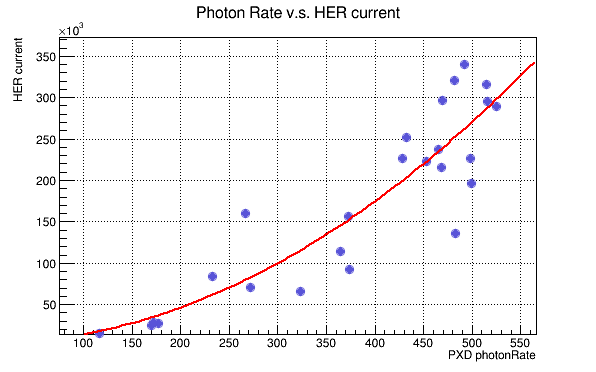

In [133]:
# average in every 50 runs


s=slice(0,-50)
interval=20

length = len(data['run'][s])

avg={}
avg[gRate] = []
avg[her] = []

for i in range(0,length,interval):
    if i+50>length:
        avg[gRate].append(np.nanmean(data[gRate][i:length]))
        avg[her].append(np.nanmean(data[her][i:length]))
    else:
        avg[gRate].append(np.nanmean(data[gRate][i:i+interval]))
        avg[her].append(np.nanmean(data[her][i:i+interval]))
        

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter(avg[her],avg[gRate], color='tab:blue')
# ax.set_xlabel('HER beam current')
# ax.set_ylabel('PXD photonRate')
 
    
import ROOT
ROOT.gStyle.SetOptStat(0)
from array import array

c1 = ROOT.TCanvas('c1','c1',600,400)
# c1.SetFillColor( 42 )
c1.SetGrid()

x, y = array( 'd' ), array( 'd' )

for i in range(len(avg[gRate])):
    x.append(avg[her][i])
    y.append(avg[gRate][i])

gr = ROOT.TGraph(len(avg[gRate]),x,y)
gr.SetLineColor( 2 )
gr.SetLineWidth( 4 )
gr.SetMarkerColor( 9 )
gr.SetMarkerStyle( 20 )
gr.SetTitle( 'Photon Rate v.s. HER current' )
gr.GetXaxis().SetTitle( 'PXD photonRate' )
gr.GetYaxis().SetTitle( 'HER current' )
gr.Draw( 'AP' )

gr.Fit('pol2')

c1.Draw()
# c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderSize( 12 )
c1.Modified()
c1.Update()


In [131]:
pol1 = 5.83639e+10/23
pol2 = 5.40225e+10/22
print pol1, pol2, pol1>pol2

2537560869.57 2455568181.82 True


In [187]:
## avg photon in runs

# run = 4472
# time0 = '2020-05-19 23:02'
# time1 = '2020-05-20 03:01'

run = 4728
time0 = '2020-05-22 18:04'
time1 = '2020-05-22 19:34'

#### Belle2 archiver
b2_archiver = epics_archiver.epics_archiver("172.22.16.120:17668")

#### PXD archiver
pxd_archiver = epics_archiver.epics_archiver("172.22.18.80:80")

#### SVD archiver
svd_archiver = epics_archiver.epics_archiver("172.22.18.120:17668") 

pv = gRate
    
start_datetime = datetime.datetime.strptime(time0, "%Y-%m-%d %H:%M")
stop_datetime = datetime.datetime.strptime(time1, "%Y-%m-%d %H:%M")


try:

    if 'PXD' in pv:
        pxd_archiver_start = pxd_archiver.date_parser(start_datetime + datetime.timedelta(minutes=5))
        pxd_archiver_stop = pxd_archiver.date_parser(stop_datetime - datetime.timedelta(minutes=5))
        data = pxd_archiver.getData(pv, pxd_archiver_start, pxd_archiver_stop)

    elif 'SKB2' in pv:
        b2_archiver_start = b2_archiver.date_parser(start_datetime + datetime.timedelta(minutes=5))
        b2_archiver_stop = b2_archiver.date_parser(stop_datetime - datetime.timedelta(minutes=5))
        data = b2_archiver.getData(pv, b2_archiver_start, b2_archiver_stop)
        
except Exception as e:
    print(run, e)

print(time0, time1, pv, np.mean(data['vals']), np.max(data['vals']))


('2020-05-22 18:04', '2020-05-22 19:34', 'PXD:V:PhotonRate:RATE:cur', 432019.6040978812, 1020620.3553182882)
